## 1. Merge Root Files

In [10]:
import uproot
import os
import numpy as np
from tqdm import tqdm

def merge_files(directory, starts_with, output_name):

    file_list = []

    for file in os.listdir(directory):
        if file.endswith('.root') and not file.startswith('merge') and not file.startswith(output_name):
            if not starts_with == '' and file.startswith(starts_with):
                    file_list.append(os.path.join(directory, file))
    
    merged_file = os.path.join(directory, output_name)
    
    counter = 0
    while True:
        if not os.path.exists(f"{merged_file}{counter}.root"):
            merged_file = f"{merged_file}{counter}.root"
            break
        counter = counter + 1

    with uproot.recreate(merged_file) as f_out:
        data_dict = {}  # Dictionary to store merged data temporarily
        
        for file in tqdm(file_list, desc = "Reading files", unit = "File", leave = True):
            
            with uproot.open(file) as f_in:
                for key in f_in.keys():
                    obj = f_in[key]
                    
                    if isinstance(obj, uproot.TTree):
                        new_data = obj.arrays(library="np")
                        base_key = key.split(';')[0] # Extract base key name (ignore cycle numbers)

                        if base_key in data_dict: # If base_key is already in data_dict, concatenate data
                            existing_data = data_dict[base_key]
                            combined_data = {k: np.concatenate([existing_data[k], new_data[k]]) for k in new_data.keys() if k in existing_data}
                            data_dict[base_key] = {**existing_data, **combined_data} # Update with the combined data
                        
                        else:
                            data_dict[base_key] = new_data # If base_key is not in data_dict, add new data

        for key, data in tqdm(data_dict.items(), desc = 'Writing file', unit='data', leave = True):
            f_out[key] = data

In [122]:
directory = 'BUILD/ROOT'
starts_with = 'root0'
output_name = 'merge'

merge_files(directory, starts_with, output_name)

Writing file: 100%|██████████| 1/1 [00:21<00:00, 21.48s/data]


## 2. Cut and Rename Root File

In [15]:
import uproot
import uproot.writing

def ModifyRoot(directory, root_name, tree_name, branch_names, output_name, new_tree_name, new_branch_names):

    input_file = directory + root_name + '.root'
    with uproot.open(input_file) as file:       
        tree = file[tree_name]
        branches = tree.arrays(branch_names, library="np")
        
    output_file = directory + output_name
    counter = 1
    while True:
        if not os.path.exists(f"{output_file}{counter}.root"):
            output_file = f"{output_file}{counter}.root"
            break
        counter = counter + 1

    with uproot.recreate(output_file) as new_file:
        new_file[new_tree_name] = {new_branch_names[0]: branches[branch_names[0]],
                                   new_branch_names[1]: branches[branch_names[1]]}

In [ ]:
directory = 'RESULTS/'

root_name = '80kev_250M'
tree_name = "G4_PCM"
branch_names = ["PositionX", "PositionY"]

output_name = 'output'
new_tree_name = "Photons"
new_branch_names = ["X_axis", "Y_axis"]

ModifyRoot(directory, root_name, tree_name, branch_names, output_name, new_tree_name, new_branch_names)

## 3. Root to Dataframe

In [11]:
import uproot
import os
import numpy as np
import dask.array as da
import dask.dataframe as dd

def root_to_dask(directory, root_name_starts, tree_name, x_branch, y_branch):
    
    file_name = os.path.join(directory, root_name_starts + ".root")

    with uproot.open(file_name) as root_file:
        tree = root_file[tree_name]
        if tree is None:
            print(f"Tree '{tree_name}' not found in {file_name}")
            return

        x_values = tree[x_branch].array(library="np") if x_branch in tree else print('error_x')
        y_values = tree[y_branch].array(library="np") if y_branch in tree else print('error_y')

        decimal_places = 2

        if x_values is not None:
            x_values = np.round(x_values, decimal_places)
        if y_values is not None:
            y_values = np.round(y_values, decimal_places)

        if x_values is None or y_values is None:
            print(f"Could not retrieve data for branches {x_branch} or {y_branch}")
            return

        x_dask_array = da.from_array(x_values, chunks="auto")
        y_dask_array = da.from_array(y_values, chunks="auto")

        dask_df = dd.from_dask_array(da.stack([x_dask_array, y_dask_array], axis=1), columns=[x_branch, y_branch])
        
        return dask_df

In [15]:
directory = 'RESULTS/'
root_name_starts = "nosecondaries"

directory = '/Volumes/GIECC/Geant4/Roots'
root_name_starts = "RC40K100M"

tree_name = "Photons"
x_branch  = "X_axis"
y_branch  = "Y_axis"

dataframe = root_to_dask(directory, root_name_starts, tree_name, x_branch, y_branch)

x_data = dataframe[x_branch].to_dask_array(lengths=True)
y_data = dataframe[y_branch].to_dask_array(lengths=True)

## 4. Dask Dataframe to Heatmap

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import dask.array as da
import dask.dataframe as dd

def heatmap_array_dask(x_data, y_data, size, save_as):

    x_shift = 0.0
    y_shift = -150.0

    x_data_shifted = x_data - x_shift
    y_data_shifted = y_data - y_shift

    pixel_size = 0.5 # mm
    set_bins = np.arange(-size, size + pixel_size, pixel_size)
    heatmap, x_edges, y_edges = da.histogram2d(x_data_shifted, y_data_shifted, bins = [set_bins, set_bins])
    heatmap = heatmap.T
    heatmap = np.rot90(heatmap, 2)
    # print(heatmap.shape)

    maplength = 100 #mm
    particles_num = 100 * 1e6
    pixel_array = np.arange(-maplength, maplength, pixel_size)
    pixel_num = len(pixel_array) ** 2
    I0 = particles_num / pixel_num #particles per pixel
    # print('Photons per pixel:', I0)

    heatmap = heatmap.compute()  
    x_edges = x_edges.compute()  
    y_edges = y_edges.compute()

    # print(np.max(heatmap))
    normal_map = 1 - heatmap / np.max(heatmap)
    # normal_map = heatmap
    normal_map = normal_map + 1

    columns = heatmap.shape[1]
    column_i = int(columns * 0.1)
    column_j = int(columns * 0.9)

    rows = heatmap.shape[0]
    row_i = int(rows * 0.01)
    row_j = int(rows * 0.1)

    maxi = np.max(normal_map[row_i:row_j, column_i:column_j])
    maxi = maxi * 1.1
    # print('altura de ruido:', round(maxi, 4))
    # normal_map[normal_map < maxi] = 0

    plt.figure(figsize = (10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(normal_map, cmap = 'gray', extent = [x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]])
    plt.axis('off')
    if save_as != '': plt.savefig('Results/' + save_as + '.png', bbox_inches = 'tight', dpi = 900)
    plt.subplot(1, 2, 2)
    plt.plot(normal_map[rows//2,:])

    return normal_map, x_edges, y_edges

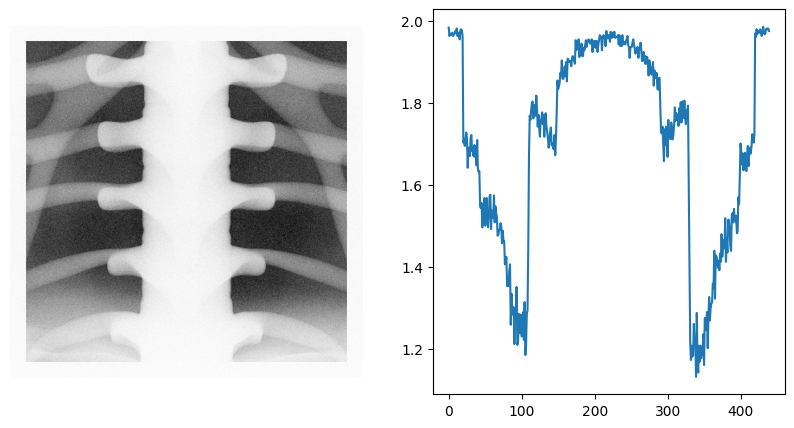

In [20]:
size = 110

save_as = ''

htmp_array, xlim, ylim = heatmap_array_dask(x_data, y_data, size, save_as)

## 5. Isolate Bone from Tissue

In [128]:
del dataframe_1, dataframe_2

In [13]:
directory = 'RESULTS/'

directory = '/Volumes/GIECC/Geant4/Roots'
rootnames = ["RC40K100M", "RC80K100M"]

tree_name = "Photons"
x_branch  = "X_axis"
y_branch  = "Y_axis"

save_as = ''

size = 120

Dataframes created


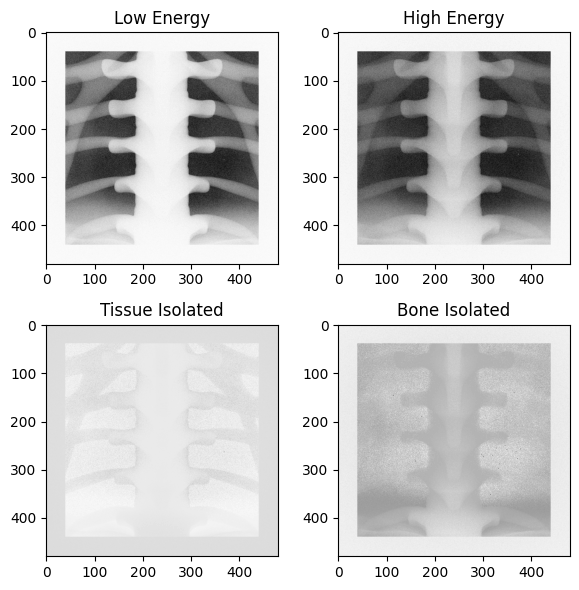

In [14]:
import Isolate_Bone as commet
import matplotlib.pyplot as plt

try: dataframe_1
except NameError:
    dataframe_1 = root_to_dask(directory, rootnames[0], tree_name, x_branch, y_branch)
    dataframe_2 = root_to_dask(directory, rootnames[1], tree_name, x_branch, y_branch)
    print("Dataframes created")

x_1 = dataframe_1[x_branch].to_dask_array(lengths=True)
y_1 = dataframe_1[y_branch].to_dask_array(lengths=True)

x_2 = dataframe_2[x_branch].to_dask_array(lengths=True)
y_2 = dataframe_2[y_branch].to_dask_array(lengths=True)

htmp_array_1, xlim, ylim = heatmap_array_dask(x_1, y_1, size, '')
htmp_array_2, xlim, ylim = heatmap_array_dask(x_2, y_2, size, '')

low_energy_img  = htmp_array_1
high_energy_img = htmp_array_2

low_energy_img  = (low_energy_img * 255).astype(np.uint8)
high_energy_img = (high_energy_img * 255).astype(np.uint8)

ratioT  = 0.5965832666477631
ratioTb = 0.4005832630201679

tissue_sls, bone_sls    = commet.sls(low_energy_img, high_energy_img, ratioT, ratioTb) # Factor de ponderación w
tissue_ssh, bone_ssh    = commet.ssh(low_energy_img, high_energy_img, ratioT, ratioTb, 0.1) # Parámetro sigma para el filtro gaussiano
tissue_acnr, bone_acnr  = commet.acnr(low_energy_img, high_energy_img, ratioT, ratioTb, 0.1) # Aplicar ACNR

bone_isolated = bone_acnr
tissue_isolated = tissue_acnr

plt.close()
plt.close()

if np.max(bone_isolated) > -1*np.min(bone_isolated):
    bone = bone_isolated / np.max(bone_isolated)
else:
    bone = bone_isolated / (-1 * np.min(bone_isolated))

bone = bone + 1
bone[bone >= 1] = 0
bone = bone / np.max(bone)

tissue = tissue_isolated / np.max(tissue_isolated)

fig, ax = plt.subplots(2, 2, figsize=(6, 6))

img1 = ax[0, 0].imshow(low_energy_img, cmap='gray')
ax[0, 0].set_title("Low Energy")
img2 = ax[0, 1].imshow(high_energy_img, cmap='gray')
ax[0, 1].set_title("High Energy")

img7 = ax[1, 0].imshow(tissue, cmap='gray')
ax[1, 0].set_title("Tissue Isolated")
img8 = ax[1, 1].imshow(bone, cmap='gray')
ax[1, 1].set_title("Bone Isolated")

plt.tight_layout()
if save_as != '': plt.savefig('Results/' + save_as + '.png', bbox_inches = 'tight', dpi = 900)
plt.show()

In [ ]:
save_as = ''
array = bone

plt.imshow(array, cmap = 'gray')
plt.axis('off')
if save_as != '': plt.savefig('Results/' + save_as + '.png', bbox_inches = 'tight', dpi = 900)
plt.show()

## 6.1. Calculate Interactive CNR

In [12]:
from PIL import Image

image_name = '40k_double_100M' + '.png'

image = Image.open('RESULTS/' + image_name)
image = image.convert('L')

cropped_image = image
# cropped_image = image.crop((1000, 1300, image.width - 1000, image.width - 1300))
# cropped_image = image.crop((650, 1100, image.width - 650, image.width - 1100))
# cropped_image = image.crop((520, 450, image.width - 580, image.width - 440))

# Interactive_CNR(cropped_image)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
%matplotlib widget
%matplotlib tk

data = np.array(cropped_image)

fig, ax = plt.subplots()
heatmap = ax.imshow(data, cmap = 'gray')

rectangles = []
start_pos = None
signal_avg = 0
background_avg = 0
background_std = 0

def on_press(event):

    global start_pos, rectangles
    if event.inaxes != ax: return
    start_pos = (event.xdata, event.ydata)
    rect = plt.Rectangle(start_pos, 1, 1, fill = False, color = 'yellow', lw = 2)
    ax.add_patch(rect)
    rectangles.append(rect)
    
    if len(rectangles) > 2:
        first_rect = rectangles.pop(0)
        second_rect = rectangles.pop(0)
        first_rect.remove()
        second_rect.remove()
    
    fig.canvas.draw()

def on_motion(event):

    global start_pos
    if start_pos is None or event.inaxes != ax: return
    width = event.xdata - start_pos[0]
    height = event.ydata - start_pos[1]
    rect = rectangles[-1]  # Get the most recent rectangle
    rect.set_width(width)
    rect.set_height(height)
    fig.canvas.draw()

def on_release(event):

    global start_pos, signal_avg, background_avg, background_std
    if start_pos is None or event.inaxes != ax: return
    end_pos = (event.xdata, event.ydata)

    x1 = start_pos[0]
    y1 = start_pos[1]
    x2 = end_pos[0]
    y2 = end_pos[1]

    if len(rectangles) == 1:
        if x2 > x1:
            if y2 > y1: signal = data[round(y1):round(y2), round(x1):round(x2)]
            else:       signal = data[round(y2):round(y1), round(x1):round(x2)]
        else:
            if y2 > y1: signal = data[round(y1):round(y2), round(x2):round(x1)]
            else:       signal = data[round(y2):round(y1), round(x2):round(x1)]

        signal_avg = np.average(signal)
        print("Signal avg: "+str(signal_avg))
    else:
        if x2 > x1:
            if y2 > y1: background = data[round(y1):round(y2), round(x1):round(x2)]
            else:       background = data[round(y2):round(y1), round(x1):round(x2)]
        else:
            if y2 > y1: background = data[round(y1):round(y2), round(x2):round(x1)]
            else:       background = data[round(y2):round(y1), round(x2):round(x1)]

        background_avg = np.average(background)
        background_std = np.std(background)
        print("Background avg: "+str(background_avg))
        print("Background std dev: "+str(background_std))
        cnr = (signal_avg-background_avg)/background_std
        print("CNR: "+str(cnr)+'\n')

    start_pos = None

fig.canvas.mpl_connect('button_press_event', on_press)
fig.canvas.mpl_connect('motion_notify_event', on_motion)
fig.canvas.mpl_connect('button_release_event', on_release)

plt.show()

## 6.2. Calculate Fixed CNR 

In [14]:
from PIL import Image
import numpy as np
import numpy as np
import matplotlib.pyplot as plt

def CNR(image_path, save_as):
    
    image = Image.open(image_path)
    image = image.convert('L')
    cropped_image = image
    # cropped_image = image.crop((520, 450, image.width - 580, image.width - 440))
    # cropped_image = image.crop((650, 1100, image.width - 650, image.width - 1100))
    data = np.array(cropped_image)

    plt.imshow(data, cmap = 'gray')
    plt.axis('off')

    signal_avg = 0
    background_avg = 0
    background_std = 0

    x1_signal = 1160
    y1_signal = 1130
    x2_signal = 1740
    y2_signal = 1980

    x1_signal = 770
    y1_signal = 180
    x2_signal = 1435 
    y2_signal = 1110 

    plt.gca().add_patch(plt.Rectangle((x1_signal, y1_signal), x2_signal - x1_signal, y2_signal - y1_signal, linewidth=2, edgecolor='yellow', facecolor='none'))

    if x2_signal > x1_signal:
        if y2_signal > y1_signal:
            signal = data[round(y1_signal):round(y2_signal), round(x1_signal):round(x2_signal)]
        else:
            signal = data[round(y2_signal):round(y1_signal), round(x1_signal):round(x2_signal)]
    else:
        if y2_signal > y1_signal:
            signal = data[round(y1_signal):round(y2_signal), round(x2_signal):round(x1_signal)]
        else:
            signal = data[round(y2_signal):round(y1_signal), round(x2_signal):round(x1_signal)]

    signal_avg = np.average(signal)
    signal_std = np.std(signal)
    print("Signal avg: ", round(signal_avg, 3))

    x1_background = 1790
    y1_background = 1130
    x2_background = 1940
    y2_background = 1980

    x1_background = 1490 
    y1_background = 180 
    x2_background = 1640
    y2_background = 1120 

    plt.gca().add_patch(plt.Rectangle((x1_background, y1_background), x2_background - x1_background, y2_background - y1_background, linewidth=2, edgecolor='red', facecolor='none'))

    if x2_background > x1_background:
        if y2_background > y1_background:
            background = data[round(y1_background):round(y2_background), round(x1_background):round(x2_background)]
        else:
            background = data[round(y2_background):round(y1_background), round(x1_background):round(x2_background)]
    else:
        if y2_background > y1_background:
            background = data[round(y1_background):round(y2_background), round(x2_background):round(x1_background)]
        else:
            background = data[round(y2_background):round(y1_background), round(x2_background):round(x1_background)]

    background_avg = np.average(background)
    background_std = np.std(background)

    print("Background avg: ", round(background_avg, 3))
    print("Background std dev: ", round(background_std, 3))

    cnr = (signal_avg-background_avg)/background_std
    # cnr = (background_avg - signal_avg)/signal_std
    print("CNR: ", round(cnr, 1))

    if save_as != '': plt.savefig('RESULTS/' + save_as + '.png', bbox_inches = 'tight', dpi = 900)

In [ ]:
image_path = "RESULTS/" + "" + "osteo_bone" + ".png"
save_as = ''
CNR(image_path, save_as)

## 7. Denoise with Skimage.Denoise_Bilateral

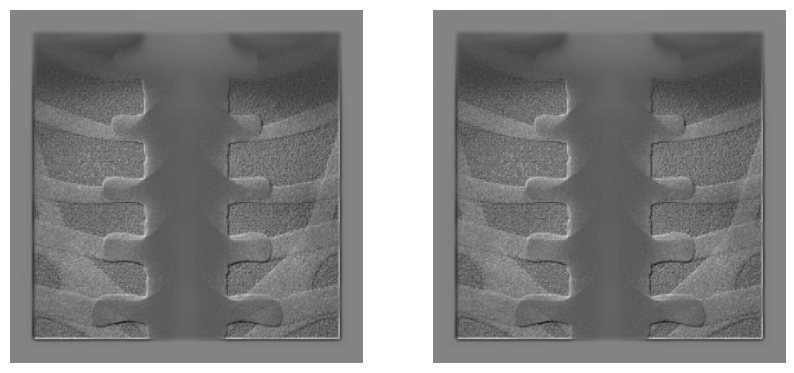

In [7]:
from skimage.restoration import denoise_bilateral
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

original_image = bone_im
# original_image = Image.open('RESULTS/bone2.png')
# original_image = np.array(original_image)
denoised_image = denoise_bilateral(original_image, sigma_color = 0.05, sigma_spatial = 20, channel_axis = None)

save_as = ''

plt.figure(figsize = (10, 5))

plt.subplot(1, 2, 1)
plt.imshow(denoised_image, cmap = 'gray')
# plt.title('Denoised Image')
plt.axis('off')
if save_as != '': plt.savefig('RESULTS/' + save_as + '.png', bbox_inches = 'tight', dpi = 900)

plt.subplot(1, 2, 2)
plt.imshow(original_image, cmap = 'gray')
# plt.title('Original Image')
plt.axis('off')

plt.show()

## 8. Save Plotly Heatmap

In [223]:
import plotly.graph_objects as go
import plotly.io as pio

def heatmap2(array, xlim, ylim, title, x_label, y_label, annotation, width, height, save_as):

    font_family = 'Merriweather'
    family_2    = 'Optima'
    font_small  = 16
    font_medium = 20
    font_large  = 18

    fig = go.Figure(go.Heatmap(z = array, x = xlim, y = ylim,
                                colorscale = [[0, 'black'], [1, 'white']], 
                                colorbar = dict(title = "Density", tickfont = dict(family = family_2, size = 15, color = 'Black'))))
    
    fig.update_layout(
                    title = dict(text = title, font = dict(family = font_family, size = font_large, color = "Black"), 
                                 x = 0.51, y = 0.93, yanchor = 'middle', xanchor = 'center'),
                    xaxis_title = dict(text = x_label, font = dict(family = font_family, size = font_medium, color = "Black")),
                    yaxis_title = dict(text = y_label, font = dict(family = font_family, size = font_medium, color = "Black")),
                    xaxis = dict(tickfont = dict(family = family_2, size = font_small, color = "Black"), title_standoff = 25),
                    yaxis = dict(tickfont = dict(family = family_2, size = font_small, color = "Black"), title_standoff = 10),
                    width = width, height = height, margin = dict(l = 105, r = 90, t = 90, b = 90),
                    annotations = [dict(x = 0.95, y = 0.15,  xref = 'paper', yref = 'paper', showarrow = False,
                                        font = dict(family = family_2, size = 15, color = "White"),
                                        bgcolor = "rgba(255, 255, 255, 0.1)", borderpad = 8, bordercolor = "White", borderwidth = 0.2,
                                        text = annotation)]
    )
   
    if save_as != '': pio.write_image(fig, 'Results/' + save_as + '.png', width = width, height = height, scale = 5)
    fig.show()

In [ ]:
# array = htmp_array
array = denoised_image
# array = fft_image
# array = bone
# array = tissue

title   = r"$ \large{ \text{Denoised Isolated Bone, DEXA: 40, 80 keV, 250M Beams} } $"
x_label = r"$ \large{ \text{X Axis} \ (mm)} $"
y_label = r"$ \large{ \text{Y Axis} \ (mm)} $"

annotation = 'CNR = 9.1' 

width  = 800
height = 800

save_as = 'denoised_dexa_bone'

heatmap2(array, xlim, ylim, title, x_label, y_label, annotation, width, height, save_as)

# Extra

## 7.2. Eliminate Noise by Fourier Transform

In [33]:
import numpy as np
from scipy.fft import fft2, fftshift, ifft2
import matplotlib.pyplot as plt
from scipy import signal

def Denoise(htmp_array, hann, alpha, save_as, cortes_transversales):

    image = htmp_array

    fft_image = fft2(image)
    fft_image = fftshift(fft_image)

    rows, cols = image.shape

    hann = False
    if hann == True:
    
        l = rows * alpha
        a = np.hanning(l)
        b = np.hanning(l)

        padding_size = rows - len(a)
        left_padding = padding_size // 2
        right_padding = padding_size - left_padding
        a = np.pad(a, (left_padding, right_padding), mode='constant')

        padding_size = cols - len(b)
        left_padding = padding_size // 2
        right_padding = padding_size - left_padding
        b = np.pad(b, (left_padding, right_padding), mode='constant')

        window = np.outer(a, b)

    else:

        a = signal.windows.tukey(rows, alpha)
        b = signal.windows.tukey(rows, alpha)
        window = np.outer(a, b)

    fft_image_2 = fft_image * (window)
    fft_image = fftshift(fft_image_2)
    fft_image = (ifft2(fft_image))
    fft_image = (np.abs(fft_image))

    if cortes_transversales == True:
        
        plt.figure(figsize = (7, 3))
        plt.subplot(1, 2, 1)
        plt.plot(a)
        plt.title('Window')
        plt.subplot(1, 2, 2)
        plt.plot(np.abs((fft_image_2[:][rows//2])))
        plt.title('F. Transform Slice')

        plt.figure(figsize = (7, 3))
        plt.subplot(1, 2, 1)
        plt.plot(image[:][rows//2])
        plt.title('Original Slice')
        plt.subplot(1, 2, 2)
        plt.plot(np.abs(fft_image[:][rows//2]))
        plt.title('Denoised Slice')

    plt.figure(figsize = (8, 4))
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(image, cmap = 'gray')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.title('Filtered Image')
    plt.imshow(fft_image, cmap = 'gray')
    plt.axis('off')
    if save_as != '': plt.savefig('Results/' + save_as + '.png', dpi = 900)
    plt.show()

    return fft_image

# =========================================================================================================================================

hann = False
alpha = 1
array = htmp_array
save_as = ''
graficas = False
fft_image = Denoise(array, hann, alpha, save_as, graficas)

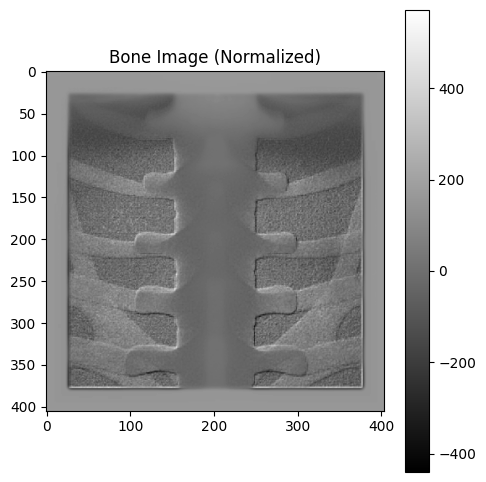

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 
from scipy.ndimage import gaussian_filter

low_energy_img = cv2.imread('RC40K100M.jpg', cv2.IMREAD_GRAYSCALE)
high_energy_img = cv2.imread('RC80K100M.png', cv2.IMREAD_GRAYSCALE)

# Paso 3: Calcular w (ejemplo)
wt = 0.5965832666477631
wb = 0.40058326302016795
w = .32
wn = .05


def acnr(low_image, high_image, w, wc, wn):
    high_filter_image = 1 -  gaussian_filter(high_energy_img,  sigma=2)
    HLfilter = wn*wc*high_filter_image - w 
    HHfilter = 1 - wn*high_filter_image

    image_ = (low_image  * HLfilter) + (high_image * HHfilter)
    return image_

bone_im = acnr(low_energy_img, high_energy_img, w, wt, wn)
# bone_im = 1/np.log(1/bone_im) 
# # Paso 6: Normalizar para visualización
# tissue_img_norm = normalize_image(tissue_img)
# bone_img_norm = normalize_image(bone_img)

# Paso 7: Visualizar
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 2)
plt.title("Bone Image (Normalized)")
plt.imshow(bone_im, cmap='gray')
plt.colorbar()

plt.show()